# Laboratorio di Simulazione Numerica: lezione 6

Elia Steve (47122A)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import subprocess

In [3]:
sys.path.append('..')
from lib_NSL_py.simulator import run_simulation, set_properties, set_config_file, remove_output

### Esercizio 6.1

In questo esercizio dobbiamo implementare l'algoritmo di Gibbs per campionare le configurazioni di un modello di Ising monodimensionale con interazione ai primi vicini, e calcolare tramite l'algoritmo di Metropolis e quello di Gibbs i valori di varie quantità per questo modello (vale a dire energia, calore specifico e suscettività magnetica per campo esterno $h$ nullo, e magnetizzazione per campo esterno $h=0.02$) per diversi valori della temperatura.

Ho calcolato l'espressione della probabilità di transizione dell'algoritmo di Gibbs con campo non nullo, che è

$$
p(s_k=\pm1|{\{s_i| i\neq k\}}) = \frac{1}{1+e^{\mp2\beta(J(s_{k-1} + s_{k+1})+h)}},
$$

dove $s_i$ è l'$i$-esimo spin.

Le simulazioni sono eseguite una dopo l'altra per 20 valori della temperatura, equispaziati fra $T=2$ e $T=0.5$ (in unità ridotte). Per la prima simulazione ho effettuato una fase di equilibrazione; le simulazioni successive partono dalla configurazione della simulazione precedente e non prevedono una fase di equilibrazione dedicata, visto che simulazioni successive vengono effettuati con valori della temperatura simili abbastanza da rendere il passaggo da configurazioni tipiche per la prima tempreatura a quelle tipiche per la seconda estremamente rapido.

In [4]:
nsl_folder = "../NSL_SIMULATOR"

Definisco alcune funzioni utili:

In [5]:
def read_last_value(filename):
    """
    Reads the progressive mean and error from the last line in a sim output file.
    
    Args:
        filename: path of the file to be read
    """
    with open(filename, "r") as f:
        f.readline() #1st line is a comment
        for line in f:
            __, __, val, err = map(float, line.strip().split())
    return val, err

In [15]:
def run_simulation_batch(nsl_folder, Ts, h):
    """
    Runs a batch of simulations at the specified values of temperature and external field.
    The simulations for the different values of temperature are run sequentially and every
    simulation except the first starts from the final configuration of the last simulation.
    For the first simulation only an equilibraton phase is run before starting the
    measurements.

    Args:
        nsl_folder: path of the NSL_SIMULATOR folder
        Ts: list of temperatures 
    """
    remove_output(nsl_folder) #Don't save the output from properties from previous runs
    
    for mode, value in [("metro", 2), ("gibbs", 3)]:
        restart = 0
        eqsteps = 5000
        for T in Ts:
            print(f"Running sim with T = {T} ({mode})")
            run_simulation(
                folder=nsl_folder,
                sim_type = value,
                restart = restart,
                H = h,
                temperature = T,
                n_part = 50,
                density = 1,
                r_cut = 0,
                delta = 0,
                n_blocks = 100,
                n_steps = 15000,
                n_eqsteps = eqsteps
            )
            subprocess.run(["rsync", "-a", "--delete", nsl_folder+"/OUTPUT/", "sim_output/OUTPUT_T"+str(T)[:4]+"_h"+str(h)+"_"+mode+"/"])
            subprocess.run(["cp", nsl_folder+"/OUTPUT/CONFIG/config.spin", nsl_folder+"/INPUT/CONFIG/config.spin"])
            restart = 1
            eqsteps = 0

Imposto le temperature e scrivo i file con la configurazione iniziale appropriata per il modello di Ising:

In [7]:
Ts = np.flip(np.linspace(0.5, 2, 20))
Ts

array([2.        , 1.92105263, 1.84210526, 1.76315789, 1.68421053,
       1.60526316, 1.52631579, 1.44736842, 1.36842105, 1.28947368,
       1.21052632, 1.13157895, 1.05263158, 0.97368421, 0.89473684,
       0.81578947, 0.73684211, 0.65789474, 0.57894737, 0.5       ])

In [8]:
set_config_file(nsl_folder, "ising")

Eseguo le simulazioni:

In [9]:
#Set poperties and run simulations (h=0)

properties = ["total_energy", "specific_heat", "magnetization", "susceptibility"]
set_properties(nsl_folder, properties)

#Comment this if the simulations have been run already to prevent them from running again
#run_simulation_batch(nsl_folder, Ts, 0)

In [10]:
properties = ["magnetization"]
set_properties(nsl_folder, properties)

#Comment this if the simulations have been run already to prevent them from running again
#run_simulation_batch(nsl_folder, Ts, 0.02)

Ora facciamo il grafico dei risultati. Dato che le curve delle quantità misurate in funzione della temperatura variano su scale grandi rispetto alle incertezze su questi valori, per valutare i miei risultati disegno il grafico della differenza fra i valori misurati e quelli esatti: disegno anche le curve esatte in funzione della temperatura.

In [11]:
def internal_energy_h0(Ts, N=50, J=1):
    beta = 1/Ts
    th = np.tanh(J/Ts)
    thN= th**N
    ch = 1/th
    return -J*( th + ch*thN )/( 1 + thN )

def heat_capacity_h0(Ts, N=50, J=1):
    beta = 1/Ts
    th = np.tanh(J/Ts)
    thN= th**N
    ch = 1/th
    return ((beta*J)**2)*(((1+thN+(N-1)*(th**2)+(N-1)*(ch**2)*thN)/(1+thN))-N*((th+ch*thN)/(1+thN))**2)

def magnetization(Ts, N=50, J=1, h=0.02):
    b = 1/Ts
    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**N + l2**N
    return (np.exp(b*J)*np.sinh(b*h)*((l1**(N-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
            + (l2**(N-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

def susceptibility_h0(Ts, N=50, J=1):
    beta = 1/Ts
    th = np.tanh(J/Ts)
    thN= th**N
    return beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

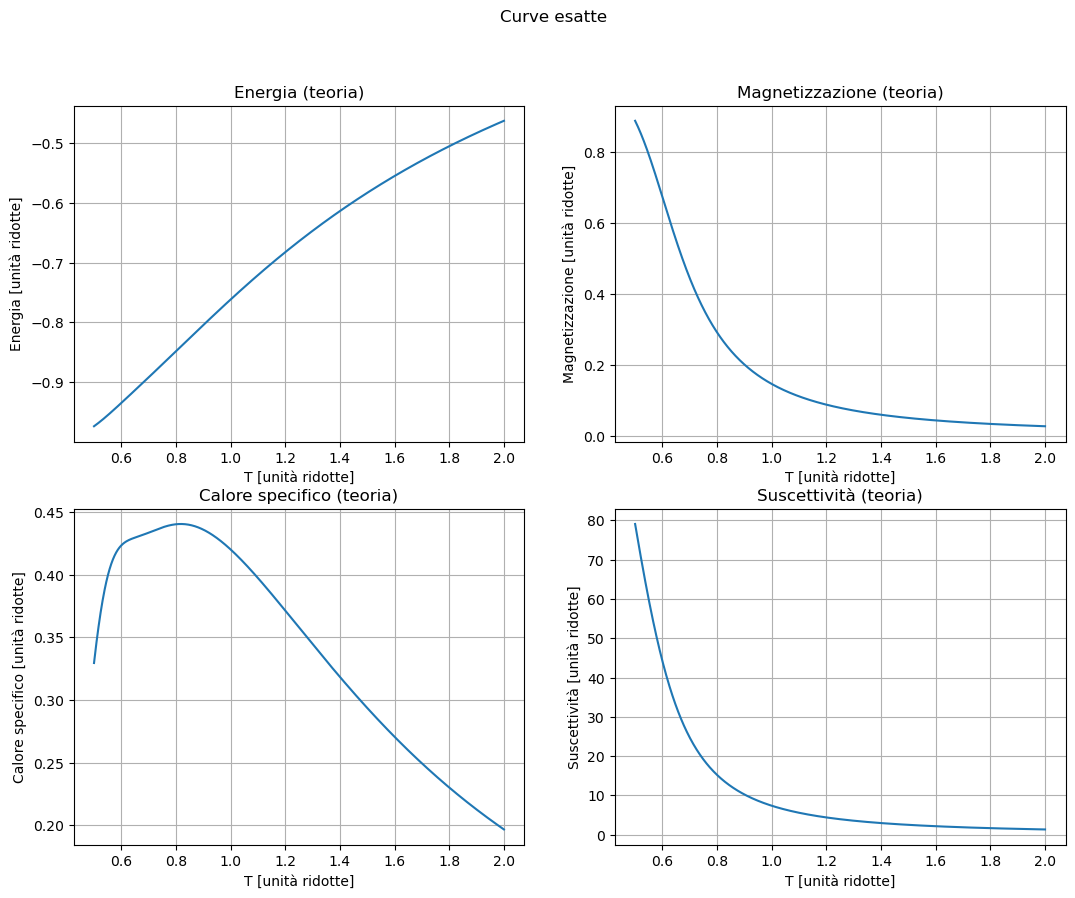

In [12]:
Ts_test = np.linspace(0.5, 2, 1000)
fig_th, ((ax_energy_th, ax_m_th), (ax_cv_th, ax_chi_th)) = plt.subplots(2, 2, figsize=(12.8, 9.6))
fig_th.suptitle("Curve esatte")

for function, title, ax in zip(
    [internal_energy_h0, magnetization, heat_capacity_h0, susceptibility_h0],
    ["Energia", "Magnetizzazione", "Calore specifico", "Suscettività"],
    [ax_energy_th, ax_m_th, ax_cv_th, ax_chi_th]
):
    ax.plot(Ts_test, function(Ts_test))
    ax.set_title(title + " (teoria)")
    ax.set_xlabel("T [unità ridotte]")
    ax.set_ylabel(title + " [unità ridotte]")
    ax.grid()

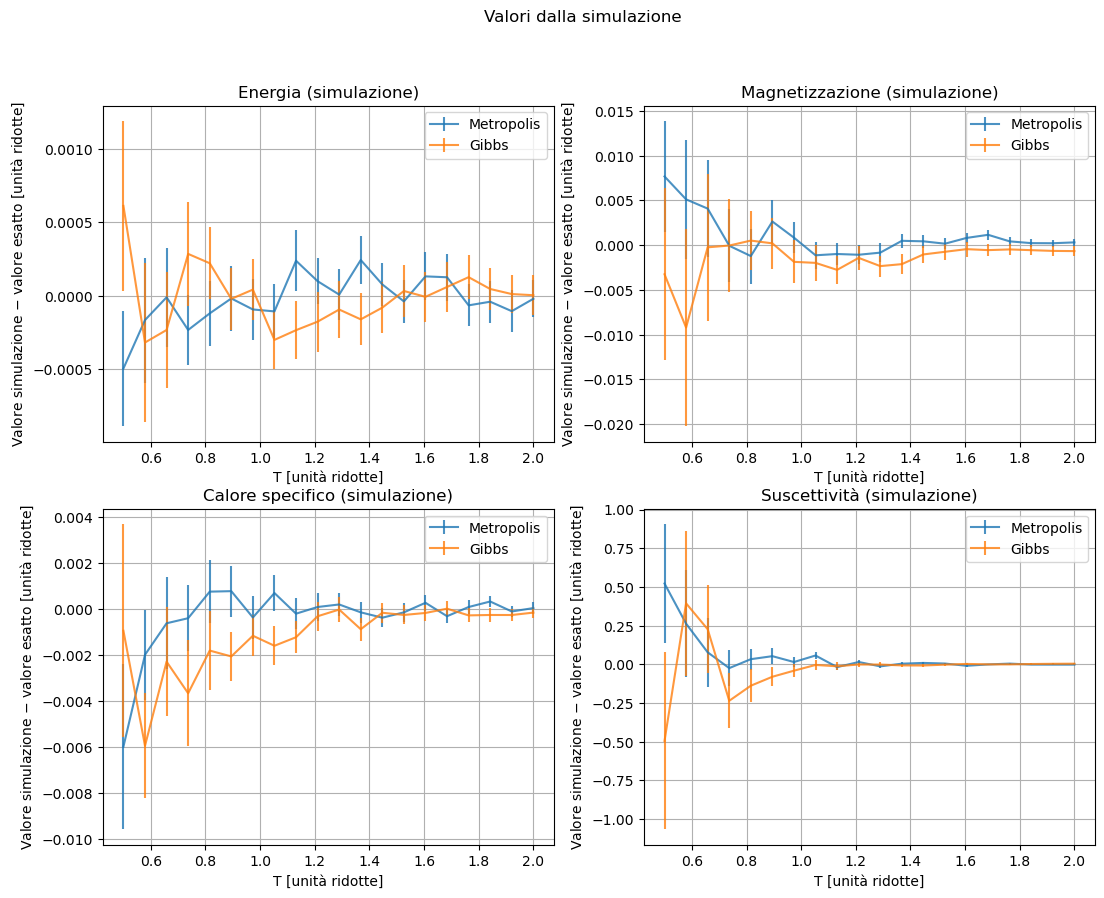

In [17]:
fig_exp, ((ax_energy_exp, ax_m_exp), (ax_cv_exp, ax_chi_exp)) = plt.subplots(2, 2, figsize=(12.8, 9.6))
fig_exp.suptitle("Valori dalla simulazione")

for property, function, ax, title in zip(
    ["total_energy", "magnetization", "specific_heat", "susceptibility"],
    [internal_energy_h0, magnetization, heat_capacity_h0, susceptibility_h0],
    [ax_energy_exp, ax_m_exp, ax_cv_exp, ax_chi_exp],
    ["Energia", "Magnetizzazione", "Calore specifico", "Suscettività"]
):
    for mode, label in zip(["metro", "gibbs"], ["Metropolis", "Gibbs"]):
        p = []
        for T in Ts:
            if property == "magnetization":
                h = 0.02
            else:
                h = 0
            p.append(read_last_value("sim_output/OUTPUT_T"+str(T)[:4]+"_h"+str(h)+"_"+mode+"/"+property+".dat"))
        p = np.array(p)
        #print(p)
        #plt.plot(Ts_test, function(Ts_test))
        __ = ax.errorbar(Ts, p[:, 0]-function(Ts), p[:, 1], label=label, alpha=0.8)
    ax.legend()
    ax.set_title(title + " (simulazione)")
    ax.set_ylabel(r"Valore simulazione $-$ valore esatto [unità ridotte]")
    ax.set_xlabel("T [unità ridotte]")
    ax.grid()

Osserviamo che:

* la compatibilità con i valori esatti è buona in tutti i casi.
* L'algoritmo di Metropolis e quello di Gibbs forniscono risultati equivalenti.
* L'incertezza sul valore finale della simulazione tende a decrescere al crescere della temperatura. Questo probabilmente è dovuto al fatto che all'abbassarsi della temperatura si allunga la scala di tempo in cui il sistema esplora configurazioni diverse (il sistema è "meno ergodico"), e questo induce una maggiore variabilità nei risultati.